# EhV Quality control

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [2]:
from ehv.masking import plot_scip_segmentation
from ehv.core import plot_gate_czi

In [3]:
from umap import UMAP
import time
import math
import pyarrow.parquet as pq
from scip.masking import threshold
from scip.masking import util
from scip.features import texture
import flowutils
from pandas.api.types import CategoricalDtype

In [4]:
from aicsimageio import AICSImage

## SCIP computed features

## Load processed frame

In [5]:
df = pq.read_table("/data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/results/scip/202203021530/features.parquet").to_pandas()

## Meta information

<AxesSubplot:xlabel='count', ylabel='meta_panel'>

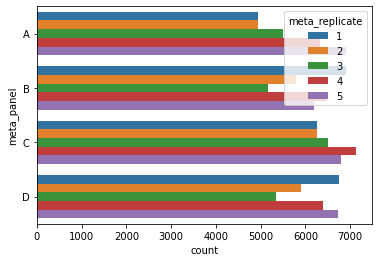

In [6]:
seaborn.countplot(data=df, y="meta_panel", hue="meta_replicate")

In [7]:
# for now only continue with objects from panel D
df = df[df["meta_panel"] == "D"]
df.shape

(31100, 1497)

## NaN values

In [8]:
# show all NaN columns
df.columns[df.isna().all(axis=0)]

Index([], dtype='object')

## Low variance features

In [9]:
v = df.filter(regex="feat").var()

In [10]:
v.isna().sum()

0

In [11]:
low_var = df.filter(regex="feat").columns[df.filter(regex="feat").var() < 0.001]

In [12]:
low_var

Index(['feat_euler_number_combined', 'feat_solidity_combined',
       'feat_moments_central-0-1_combined',
       'feat_moments_central-1-0_combined', 'feat_moments_hu-0_combined',
       'feat_moments_hu-1_combined', 'feat_moments_hu-2_combined',
       'feat_moments_hu-3_combined', 'feat_moments_hu-4_combined',
       'feat_moments_hu-5_combined',
       ...
       'feat_combined_glcm_std_homogeneity_5_PGC',
       'feat_combined_glcm_mean_energy_3_PGC',
       'feat_combined_glcm_mean_energy_5_PGC',
       'feat_combined_glcm_std_energy_3_PGC',
       'feat_combined_glcm_std_energy_5_PGC',
       'feat_combined_glcm_std_correlation_3_PGC',
       'feat_combined_glcm_mean_ASM_3_PGC',
       'feat_combined_glcm_mean_ASM_5_PGC', 'feat_combined_glcm_std_ASM_3_PGC',
       'feat_combined_glcm_std_ASM_5_PGC'],
      dtype='object', length=228)

In [13]:
df = df.drop(columns=low_var)

# Detecting multiplets that are missed during segmentation

In [14]:
aspect_ratio = df["feat_major_axis_length_Bright"] / df["feat_minor_axis_length_Bright"]

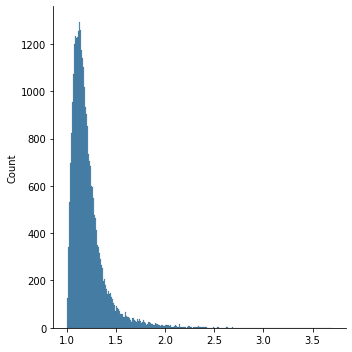

In [15]:
seaborn.displot(data=aspect_ratio)

0 P15-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P17-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P17-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P18-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P18-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P24-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P3-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P5-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P5-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P8-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi


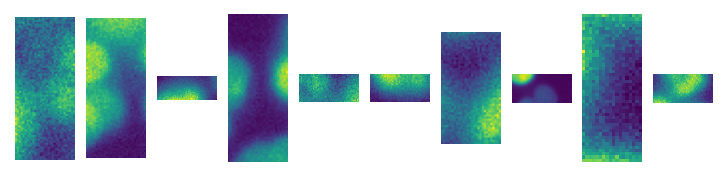

In [16]:
sel1 = aspect_ratio > 2
plot_gate_czi(sel1, df, maxn=10)

In [17]:
df = df[~sel1]
df.shape

(30850, 1269)

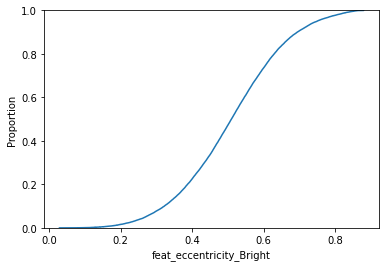

In [18]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_Bright")

0 P10-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P13-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P13-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P14-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P16-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P20-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P5-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P8-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P9-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi


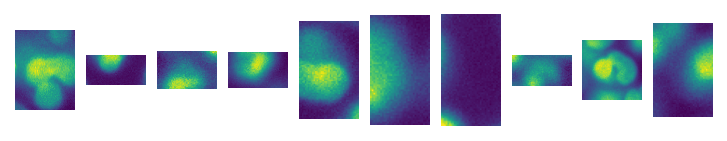

In [19]:
sel1 = df["feat_eccentricity_Bright"] > 0.75
plot_gate_czi(sel1, df, maxn=10)

In [20]:
df = df[~sel1]
df.shape

(29358, 1269)

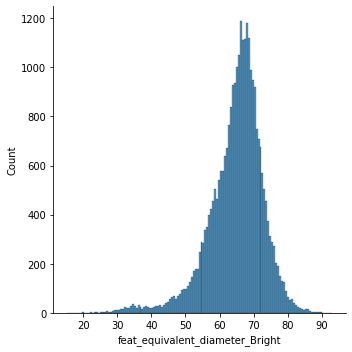

In [21]:
seaborn.displot(data=df, x="feat_equivalent_diameter_Bright")

0 P10-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P17-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P19-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P21-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P9-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi


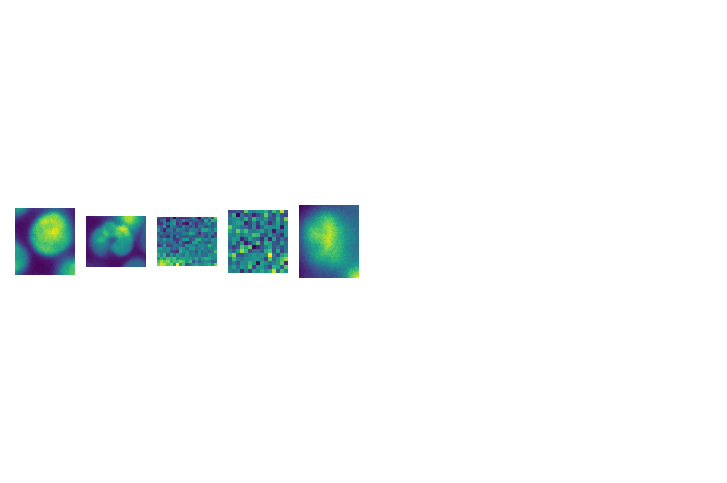

In [22]:
sel1 = df["feat_equivalent_diameter_Bright"].between(0, 20)
plot_gate_czi(sel1, df, maxn=15)

# Texture features

<AxesSubplot:xlabel='feat_glcm_mean_homogeneity_5_Bright', ylabel='feat_area_Bright'>

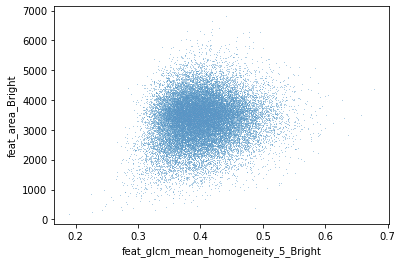

In [23]:
seaborn.scatterplot(data=df, x="feat_glcm_mean_homogeneity_5_Bright", y="feat_area_Bright", s=1, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

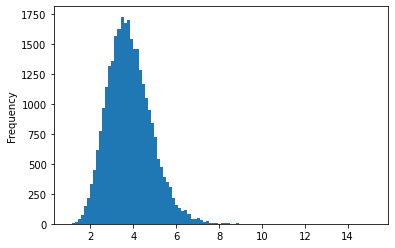

In [24]:
df["feat_glcm_mean_contrast_3_Bright"].plot.hist(bins=100)

0 P12-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P12-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P19-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P21-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi


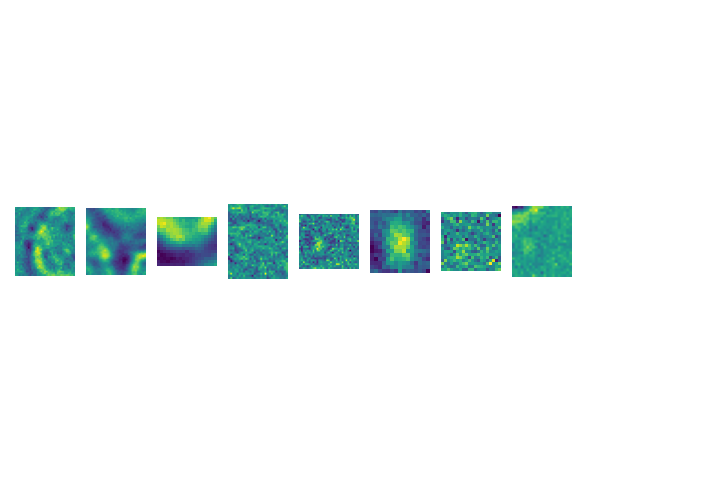

In [25]:
sel1 = df["feat_glcm_mean_contrast_3_Bright"] > 10
plot_gate_czi(sel1, df, maxn=15, channel=4)

In [26]:
df = df[~sel1]
df.shape

(29350, 1269)

<AxesSubplot:>

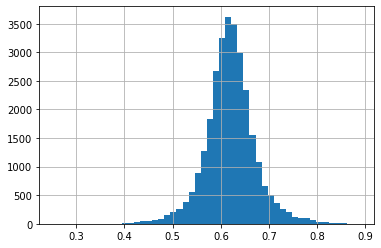

In [27]:
df["feat_glcm_mean_homogeneity_3_DAPI"].hist(bins=50)

0 P11-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P11-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P12-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P12-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P12-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P15-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P16-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P16-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P16-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P20-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P21-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P7-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P9-D5 /data/gent/vo/000/gvo

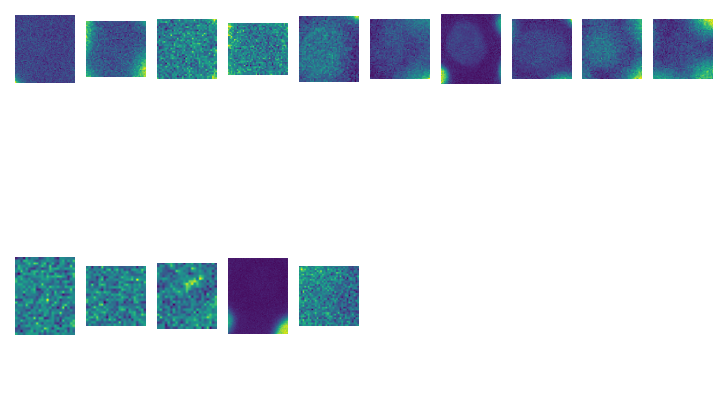

In [28]:
sel1 = df["feat_glcm_mean_homogeneity_3_DAPI"] < .4
plot_gate_czi(sel1, df, maxn=15, channel=0)

In [29]:
df = df[~sel1]
df.shape

(29321, 1269)

# Outlier features or rows

### Normality

In [195]:
from scipy.stats import normaltest
from sklearn.preprocessing import PowerTransformer

In [196]:
for col in df.filter(regex="feat"):
    r = normaltest(df[col])
    if r.pvalue > 0.05:
        print(col)

In [197]:
for col in df.filter(regex="feat"):
    if df[col].min() >= 0:
        r = normaltest(numpy.log(df[col]))
        if r.pvalue > 0.05:
            print(col)

/apps/gent/CO7/skylake-ib/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/apps/gent/CO7/skylake-ib/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/scipy/stats/stats.py:951: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


### Inter-quartile range

In [303]:
cols, amount = [], []
for col in df.drop(columns=df.filter(regex="(TMR|Cy5)$")).filter(regex="feat"):
    q1, q3 = numpy.percentile(df[col], [25, 75])
    cutoff = q3 + (q3-q1)*1.5
    a = (df[col] > cutoff).sum()
    if a > 0:
        cols.append(col)
        amount.append(a)
        
amount = numpy.array(amount)
cols = numpy.array(cols)

In [304]:
len(cols)

557

(array([122.,  76.,  81.,  63.,  69.,  40.,  45.,  48.,  10.,   3.]),
 array([1.00000e+00, 1.46970e+03, 2.93840e+03, 4.40710e+03, 5.87580e+03,
        7.34450e+03, 8.81320e+03, 1.02819e+04, 1.17506e+04, 1.32193e+04,
        1.46880e+04]),
 <a list of 10 Patch objects>)

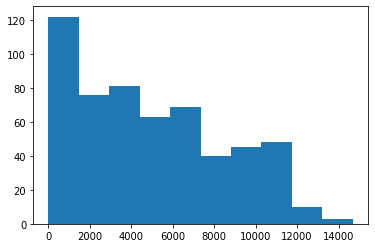

In [305]:
plt.hist(amount)

In [306]:
tmp = cols[numpy.where(amount > 12000)]

In [307]:
tmp[0]

'feat_moments-2-3_combined'

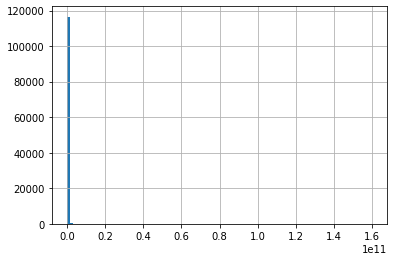

In [308]:
df[tmp[0]].hist(bins=100)

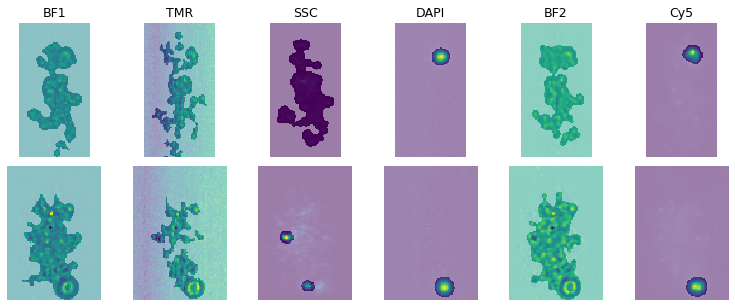

In [309]:
sel1 = df[tmp[0]] > 1e11
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [310]:
tmp[1]

'feat_moments-3-2_combined'

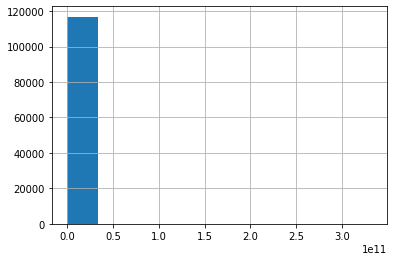

In [311]:
df[tmp[1]].hist()

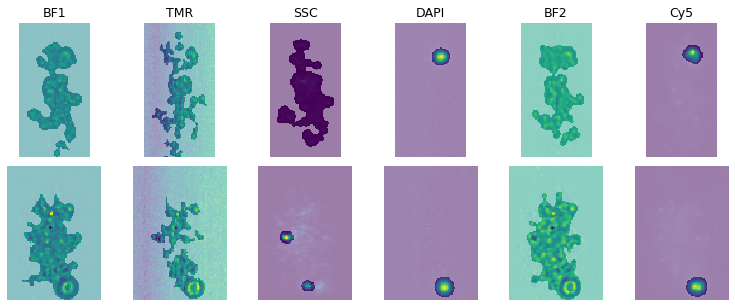

In [312]:
sel1 = df[tmp[1]] > 1e11
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

### Normalized variance

In [198]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

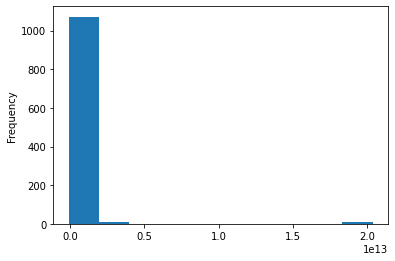

In [199]:
norm_var.plot.hist()

In [200]:
inf_features = norm_var[norm_var.abs() == numpy.inf]

In [201]:
inf_features

Series([], dtype: float64)

In [202]:
for f in inf_features.index:
    s = len(df)
    v = df[f].var()
    while abs(v) == numpy.inf:
        if abs(df[f].min()) > abs(df[f].max()):
            df = df.drop(index=df[f].idxmin())
        else:
            df = df.drop(index=df[f].idxmax())
        v = df[f].var()
    print("Dropped %d rows for %s" % (s-len(df), f))

In [203]:
norm_var[norm_var > 1e10]

feat_moments-2-3_combined            3.053522e+11
feat_moments-3-2_combined            3.025440e+11
feat_moments-3-3_combined            2.037094e+13
feat_moments_central-3-3_combined    2.687923e+12
feat_moments-2-3_DAPI                3.053522e+11
feat_moments-3-2_DAPI                3.025440e+11
feat_moments-3-3_DAPI                2.037094e+13
feat_moments_central-3-3_DAPI        2.687923e+12
feat_moments-2-3_EGFP                3.053522e+11
feat_moments-3-2_EGFP                3.025440e+11
feat_moments-3-3_EGFP                2.037094e+13
feat_moments_central-3-3_EGFP        2.687923e+12
feat_moments-2-3_RPe                 3.053522e+11
feat_moments-3-2_RPe                 3.025440e+11
feat_moments-3-3_RPe                 2.037094e+13
feat_moments_central-3-3_RPe         2.687923e+12
feat_moments-2-3_Bright              3.053522e+11
feat_moments-3-2_Bright              3.025440e+11
feat_moments-3-3_Bright              2.037094e+13
feat_moments_central-3-3_Bright      2.687923e+12


<AxesSubplot:ylabel='Frequency'>

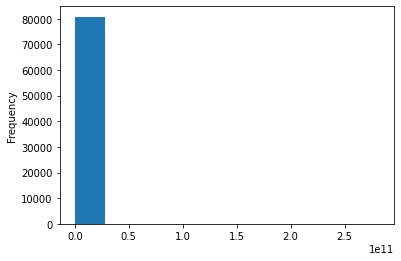

In [44]:
df["feat_moments-3-3_TMR"].plot.hist()

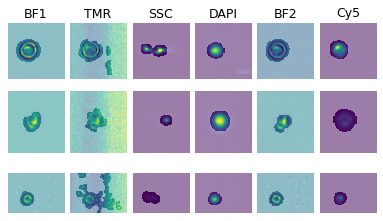

In [45]:
sel1 = df["feat_moments-3-3_TMR"] > 1e11
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [47]:
df = df[~sel1]
df.shape

(112733, 1130)

In [48]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

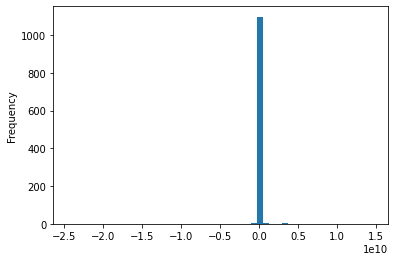

In [49]:
norm_var.plot.hist(bins=50)

In [50]:
norm_var[norm_var > 1e10]

feat_moments-3-3_TMR    1.459468e+10
dtype: float64

<AxesSubplot:ylabel='Frequency'>

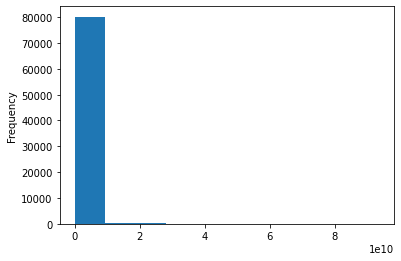

In [51]:
df["feat_moments-3-3_TMR"].plot.hist()

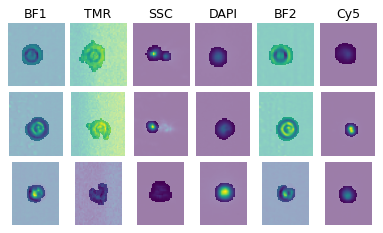

In [52]:
sel1 = df["feat_moments-3-3_TMR"] > 1e10
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [53]:
sel1.sum()

692

In [54]:
df = df[~sel1]
df.shape

(112041, 1130)

In [55]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

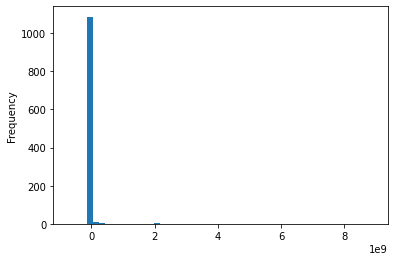

In [56]:
norm_var.plot.hist(bins=50)

In [57]:
norm_var[norm_var > 1e9]

feat_moments-3-3_combined       6.023222e+09
feat_moments-3-3_TMR            2.746597e+09
feat_moments-3-3_SSC            2.098211e+09
feat_moments-3-3_BF2            8.902491e+09
feat_moments_central-3-2_BF2    2.107739e+09
feat_moments-3-3_Cy5            2.554276e+09
dtype: float64

In [58]:
df = df.drop(columns=df.filter(regex="moments-3-3").columns)

In [59]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

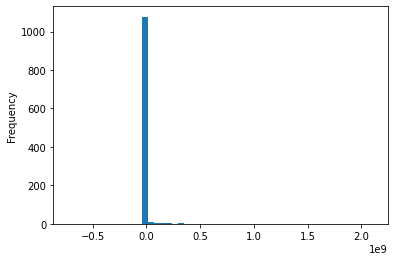

In [60]:
norm_var.plot.hist(bins=50)

In [61]:
norm_var[norm_var > 1e9]

feat_moments_central-3-2_BF2    2.107739e+09
dtype: float64

In [62]:
df = df.drop(columns=df.filter(regex="moments").columns)

In [63]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

<AxesSubplot:ylabel='Frequency'>

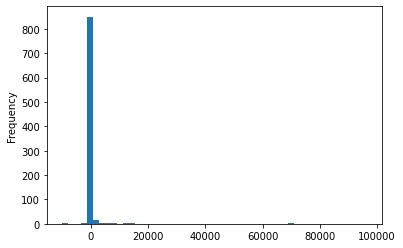

In [64]:
norm_var.plot.hist(bins=50)

In [65]:
norm_var[norm_var > 60000]

feat_sum_SSC                    68923.964801
feat_bgcorr_sum_SSC             78214.991503
feat_combined_sum_SSC           69748.976272
feat_combined_bgcorr_sum_SSC    81171.194601
feat_bgcorr_edge_sum_BF2        96353.681780
dtype: float64

<AxesSubplot:ylabel='Frequency'>

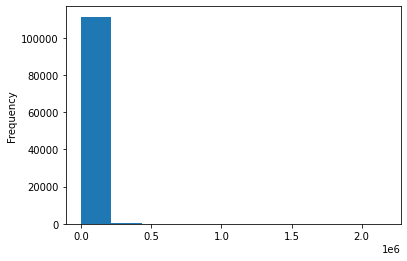

In [66]:
df["feat_sum_SSC"].plot.hist()

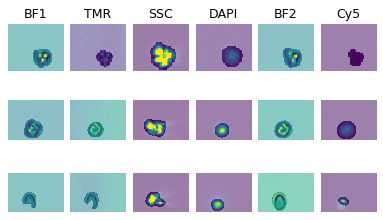

In [106]:
sel1 = df["feat_sum_SSC"] > 400000
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

### Isolation forest

In [204]:
from sklearn.ensemble import IsolationForest

In [205]:
iso = IsolationForest(n_estimators=100, random_state=0, n_jobs=5, contamination=0.05)
iso.fit(
    df.filter(regex="feat")
    .fillna(0)
    .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

/data/gent/420/vsc42015/python_lib_skitty/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.05, n_jobs=5, random_state=0)

In [206]:
pred = iso.predict(
    df.filter(regex="feat")
    .fillna(0)
    .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

0 P1-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P12-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P13-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P18-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P21-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P3-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P5-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P9-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi


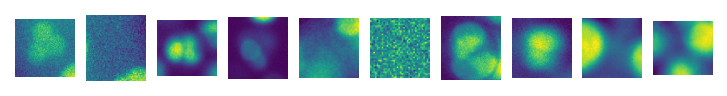

In [208]:
plot_gate_czi(pred == -1, df, maxn=10)

In [209]:
numpy.unique(pred, return_counts=True)

(array([-1,  1]), array([ 1517, 28816]))

In [246]:
from sklearn.preprocessing import robust_scale

In [247]:
df_scaled = df.copy()
df_scaled.loc[:, df.filter(regex="feat").columns] = robust_scale(df.filter(regex="feat"))

In [248]:
mu = df_scaled.filter(regex="feat").groupby(pred).mean()
diff = mu.loc[-1] - mu.loc[1]

In [249]:
diff.abs().sort_values().tail(n=20)

feat_combined_edge_upper_quartile_RPe              20.791811
feat_combined_bgcorr_edge_upper_quartile_RPe       20.791811
feat_edge_upper_quartile_RPe                       20.791811
feat_bgcorr_edge_upper_quartile_RPe                20.791811
feat_combined_edge_median_RPe                      21.125130
feat_combined_bgcorr_edge_median_RPe               21.125130
feat_bgcorr_edge_median_RPe                        21.125130
feat_edge_median_RPe                               21.125130
feat_edge_lower_quartile_Bright                    22.662321
feat_combined_edge_lower_quartile_Bright           22.662321
feat_combined_bgcorr_edge_lower_quartile_Bright    22.662321
feat_bgcorr_edge_lower_quartile_Bright             22.662321
feat_bgcorr_min_Bright                             31.105578
feat_combined_bgcorr_min_Bright                    31.105578
feat_combined_min_Bright                           31.105578
feat_min_Bright                                    31.105578
feat_bgcorr_edge_min_Bri

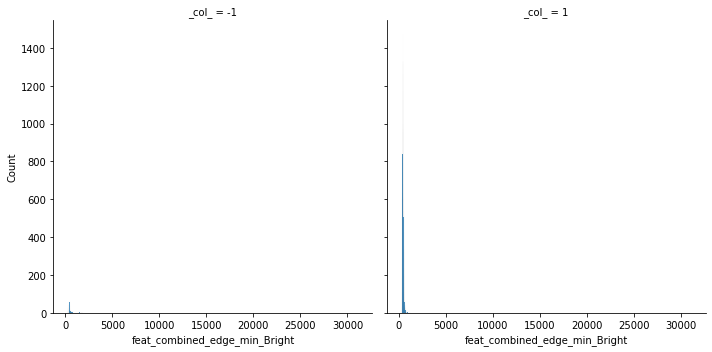

In [257]:
seaborn.displot(data=df, x="feat_combined_edge_min_Bright", kind="hist", col=pred)

0 P3-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi


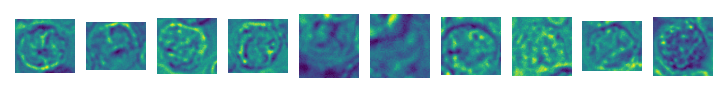

In [258]:
sel1 = df["feat_combined_edge_min_Bright"] > 25000
sel2 = pred == -1
plot_gate_czi(sel1 & sel2, df, maxn=10, channel=4)

0 P11-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P12-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P15-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P16-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P16-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P18-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P2-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P20-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P4-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P8-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi


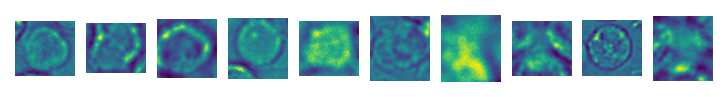

In [256]:
sel1 = df_scaled["feat_combined_edge_min_Bright"] < 100
plot_gate_czi(sel1, df, maxn=10, channel=4)

In [71]:
numpy.unique(pred, return_counts=True)

(array([-1,  1]), array([  5602, 106439]))

# Feature distributions

In [30]:
per_image_exprs = df.pivot_table(index=["meta_replicate", "meta_panel"], columns=["meta_P"], values=["feat_sum_DAPI", "feat_sum_EGFP", "feat_sum_RPe", "feat_sum_Bright"], aggfunc=numpy.mean)

In [31]:
def draw_heat(*args, data, **kwargs):
    seaborn.heatmap(
        data.set_index("meta_panel").drop(columns="meta_replicate"),
        cbar=True,
        **kwargs
    )

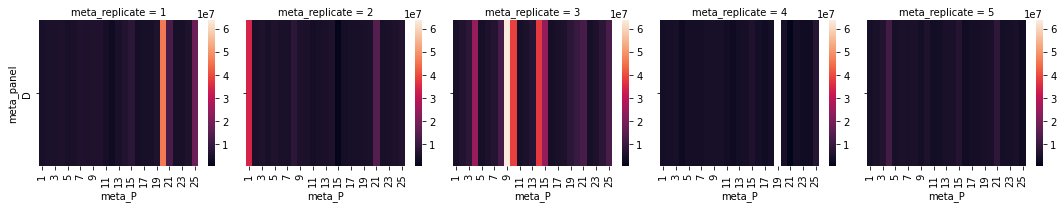

In [32]:
grid = seaborn.FacetGrid(data=per_image_exprs["feat_sum_DAPI"].reset_index(), col="meta_replicate")
grid.map_dataframe(draw_heat, vmin=per_image_exprs["feat_sum_DAPI"].min().min(), vmax=per_image_exprs["feat_sum_DAPI"].max().max())

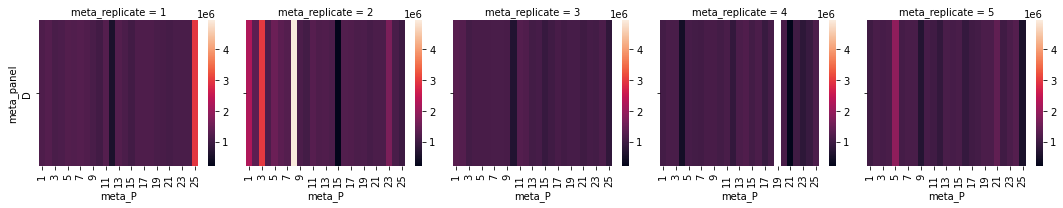

In [33]:
grid = seaborn.FacetGrid(data=per_image_exprs["feat_sum_RPe"].reset_index(), col="meta_replicate")
grid.map_dataframe(draw_heat, vmin=per_image_exprs["feat_sum_RPe"].min().min(), vmax=per_image_exprs["feat_sum_RPe"].max().max())

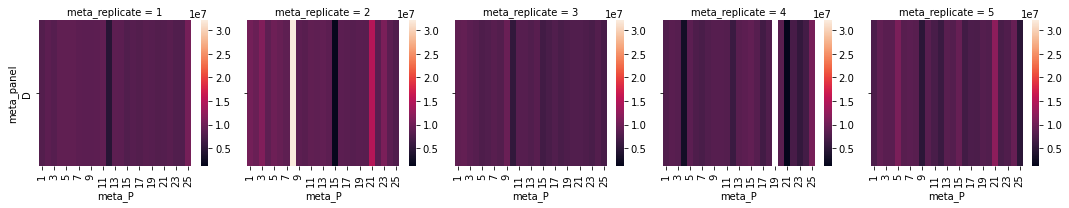

In [34]:
grid = seaborn.FacetGrid(data=per_image_exprs["feat_sum_EGFP"].reset_index(), col="meta_replicate")
grid.map_dataframe(draw_heat, vmin=per_image_exprs["feat_sum_EGFP"].min().min(), vmax=per_image_exprs["feat_sum_EGFP"].max().max())

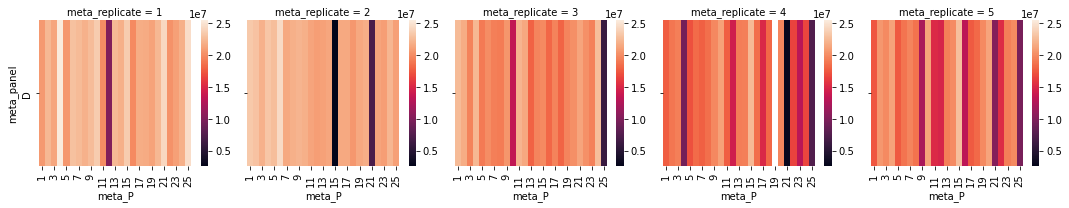

In [35]:
grid = seaborn.FacetGrid(data=per_image_exprs["feat_sum_Bright"].reset_index(), col="meta_replicate")
grid.map_dataframe(draw_heat, vmin=per_image_exprs["feat_sum_Bright"].min().min(), vmax=per_image_exprs["feat_sum_Bright"].max().max())

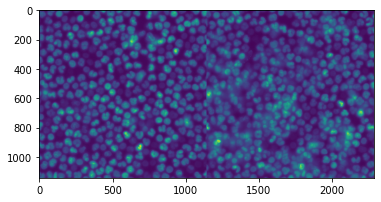

In [36]:
im = AICSImage(df["meta_path"].iloc[0], reconstruct_mosaic=False)
im.set_scene("P19-D4")
a = numpy.max(im.get_image_data("ZXY", C=0), axis=0)
im.set_scene("P2-D4")
b = numpy.max(im.get_image_data("ZXY", C=0), axis=0)

plt.imshow(numpy.hstack([a, b]))

CPU times: user 1min 17s, sys: 220 ms, total: 1min 18s
Wall time: 1min 18s


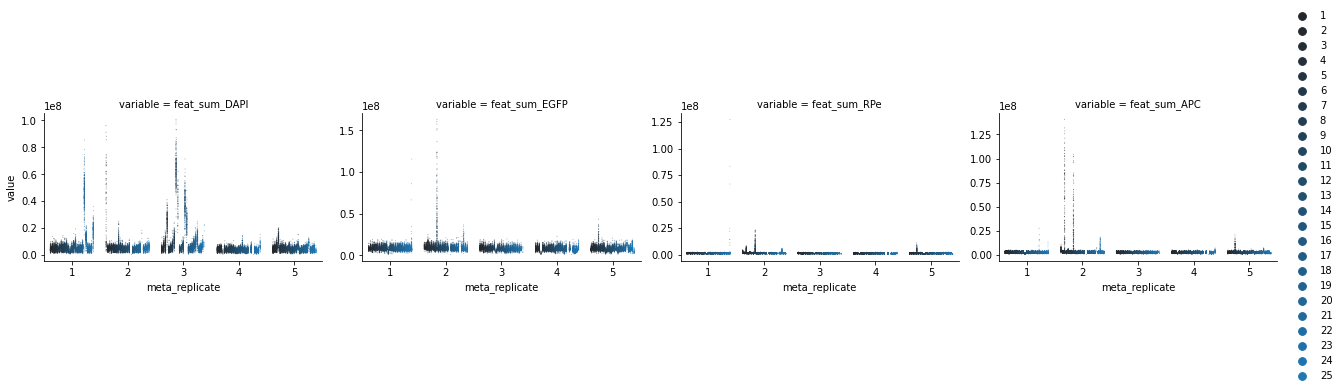

In [38]:
%%time
melted_df = pandas.melt(df, id_vars=["meta_P", "meta_replicate"], value_vars=df.filter(regex="feat_sum_(DAPI|EGFP|RPe|APC)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_replicate", y="value", hue="meta_P", dodge=True, size=1, alpha=0.5)
grid.add_legend()

In [39]:
df = df.set_index(["meta_replicate", "meta_panel", "meta_P"])
df = df.sort_index()

<AxesSubplot:xlabel='meta_P', ylabel='feat_sum_DAPI'>

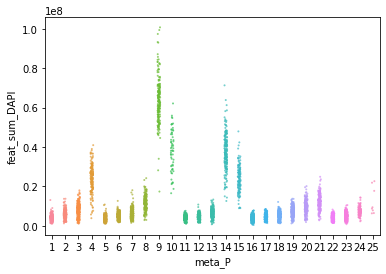

In [40]:
seaborn.stripplot(data=df.loc[3, "D"].reset_index(), y="feat_sum_DAPI", x="meta_P", s=2, alpha=0.7)

<AxesSubplot:xlabel='meta_P', ylabel='feat_sum_APC'>

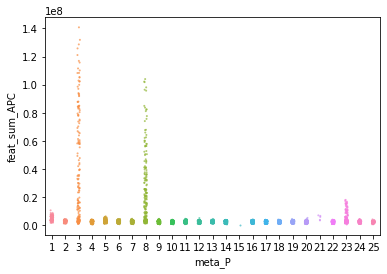

In [41]:
seaborn.stripplot(data=df.loc[2, "D"].reset_index(), y="feat_sum_APC", x="meta_P", s=2, alpha=0.7)

In [42]:
gdf = df.groupby(["meta_replicate", "meta_panel", "meta_P"])[df.filter(regex="feat_sum_(DAPI|EGFP|RPe|APC)").columns]

In [43]:
def func(x):
    q = x.quantile(q=(0.05, 0.95))
    return (x - q.loc[0.05]) / (q.loc[0.95] - q.loc[0.05])
df_mm = gdf.transform(func)
df[df_mm.columns] = df_mm

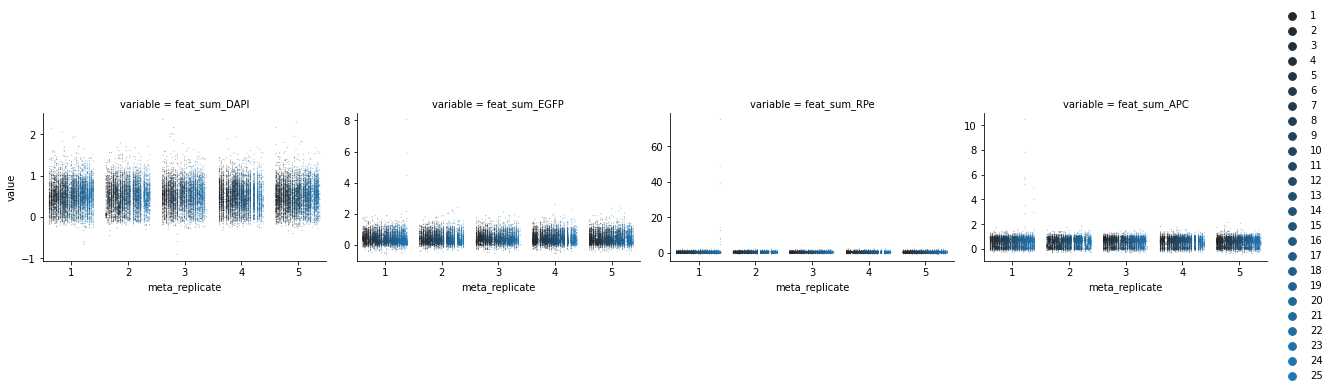

In [44]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_P", "meta_replicate"], value_vars=df.filter(regex="feat_sum_(DAPI|EGFP|RPe|APC)").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", sharey=False, aspect=1.5)
grid.map_dataframe(seaborn.stripplot, x="meta_replicate", y="value", hue="meta_P", dodge=True, size=1, alpha=0.5)
grid.add_legend()

### DAPI

<AxesSubplot:xlabel='feat_sum_DAPI', ylabel='Count'>

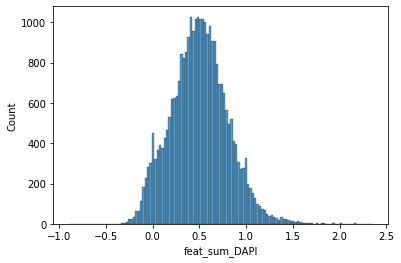

In [45]:
seaborn.histplot(data=df.reset_index(), x="feat_sum_DAPI")

<AxesSubplot:xlabel='feat_sum_DAPI', ylabel='Count'>

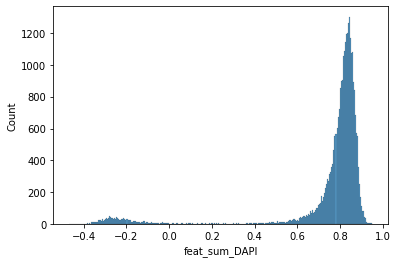

In [46]:
asinh_dapi = flowutils.transforms.asinh(df["feat_sum_DAPI"], channel_indices=None, t=4, m=4, a=1)
seaborn.histplot(data=asinh_dapi)

In [72]:
numpy.unique(asinh_dapi < 0.4, return_counts=True)

(array([False,  True]), array([27703,  1618]))

0 P10-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P12-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P14-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P18-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P19-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P2-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P20-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P22-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P22-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P24-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P25-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P4-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P9-D2 /data/gent/vo/000/gvo0

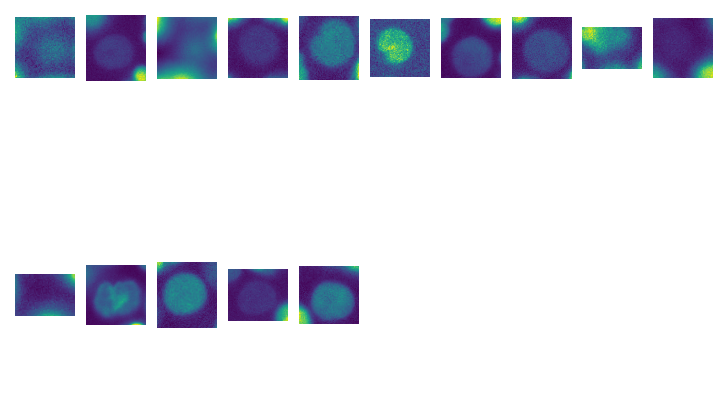

In [74]:
sel1 = asinh_dapi < 0.4
plot_gate_czi(sel1, df, maxn=15, channel=0)

0 P10-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P13-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P15-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P17-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P2-D2 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P20-D1 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P21-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P24-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P3-D4 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P4-D3 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P5-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P7-D5 /data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/Experiment-800.czi
0 P8-D2 /data/gent/vo/000/gvo0007

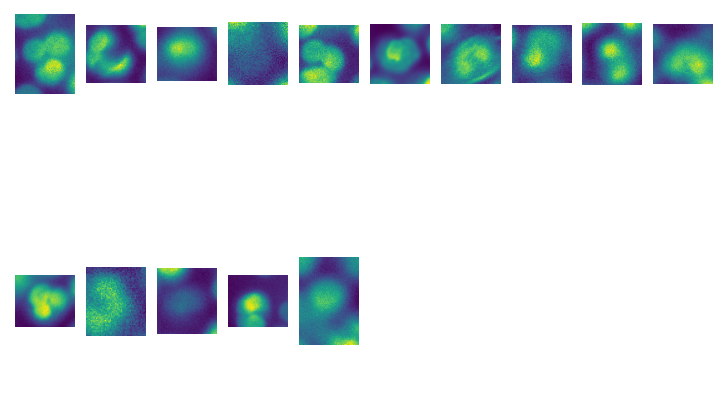

In [75]:
sel1 = asinh_dapi > 0.4
plot_gate_czi(sel1, df, maxn=15, channel=0)

In [73]:
df["meta_dapi_positive"] = asinh_dapi > 0.4

### APC (CD15)

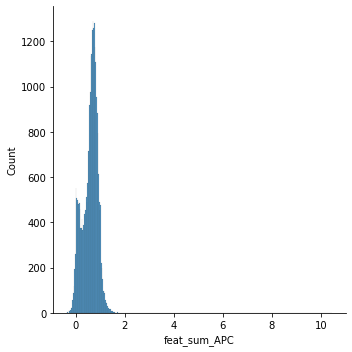

In [50]:
seaborn.displot(data=df[df["meta_dapi_positive"]].reset_index(), x="feat_sum_APC")

In [65]:
asinh_apc = flowutils.transforms.asinh(df["feat_sum_APC"], channel_indices=None, t=2, m=4, a=1)

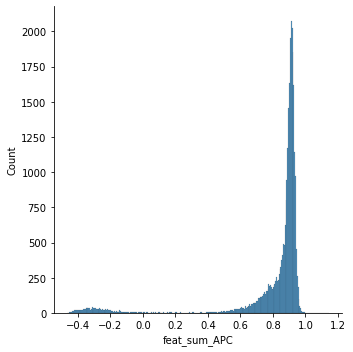

In [66]:
seaborn.displot(data=asinh_apc)

<AxesSubplot:xlabel='feat_sum_DAPI', ylabel='feat_sum_APC'>

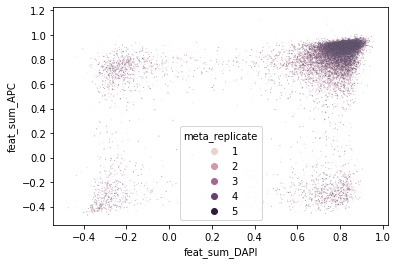

In [71]:
seaborn.scatterplot(x=asinh_dapi, y=asinh_apc, s=1, alpha=0.5, hue=df.index.get_level_values("meta_replicate"))

In [76]:
df["meta_CD15_positive"] = asinh_apc > 0.4

# Export

In [361]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/results/scip/202203021530/index.npy", df.index.values)

In [362]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/results/scip/202203021530/columns.npy", df.columns.values)

In [77]:
import pyarrow

In [85]:
df = df.reset_index()

In [86]:
sel1 = df["meta_dapi_positive"]
sel2 = df["meta_CD15_positive"]

pq.write_table(
    pyarrow.Table.from_pandas(df[sel1 & sel2][df.filter(regex="meta").columns]),
    "/data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/results/scip/202203021530/for_annotator.parquet"
)